### Code for Robust NAMLSS

In [31]:
import torch
import torch.nn as nn
import torch.distributions as dist
import torch.distributions.normal
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
import torchrl.modules.utils as utils

class NormalNAMLSS(nn.Module):
    def __init__(self, n_covariates, hidden_size=8, intercept=False):
        super(NormalNAMLSS, self).__init__()

        self.submodules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 2)
            ) for _ in range(n_covariates)
        ])

        self.use_intercept = intercept
        if self.use_intercept:
            self.intercept = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
        x = torch.stack(param_mat_list, dim=1)
        mu_components = x[:, :, 0]
        sigma_components = F.softplus(x[:, :, 1])

        mu = torch.sum(mu_components, dim=1).unsqueeze(dim=1)
        sigma = torch.sum(sigma_components, dim=1).unsqueeze(dim=1)

        if self.use_intercept:
            mu = mu + self.intercept[0]
            sigma = sigma + F.softplus(self.intercept[1])

        return mu, sigma

    def nll_loss(self, mu, sigma, y_true, robustness_factor=None):
        normal_dist = dist.Normal(mu, sigma)
        log_likelihood = normal_dist.log_prob(y_true).mean()

        if robustness_factor is not None:
            log_likelihood = torch.log((1 + torch.exp(log_likelihood + robustness_factor)) / (1 + torch.exp(robustness_factor)))

        nll = -log_likelihood
        return nll

    def fit(self, X_train, y_train, X_val=None, y_val=None, n_epochs=10000, lr=1e-3, weight_decay=0.0, 
            early_stopping_patience=10, robustness_factor=None):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(n_epochs):
            self.train()

            # Forward pass and loss computation
            mu, sigma = self.forward(X_train)
            train_loss = self.nll_loss(mu, sigma, y_train, robustness_factor)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            val_loss = None
            if X_val is not None and y_val is not None:
                self.eval()
                with torch.no_grad():
                    mu_val, sigma_val = self.forward(X_val)
                    val_loss = self.nll_loss(mu_val, sigma_val, y_val, robustness_factor).item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = self.state_dict()
                else:
                    patience_counter += 1

                if (patience_counter >= early_stopping_patience) and (epoch >= 1000):
                    print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                    self.load_state_dict(best_model_state)
                    break

            if epoch % 100 == 0 or val_loss is not None:
                print(f"Epoch {epoch} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss:.4f}" if val_loss else f"Epoch {epoch} - Train Loss: {train_loss.item():.4f}")

        return self

    def marginal_effects(self, x):
        with torch.no_grad():
            param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
            x = torch.stack(param_mat_list, dim=1)
            mu_components = x[:, :, 0].detach().cpu().numpy()
            sigma_components = F.softplus(x[:, :, 1]).detach().cpu().numpy()
        return mu_components, sigma_components

       

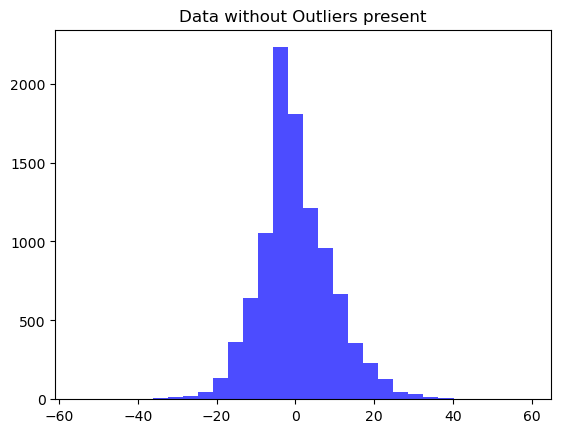

In [32]:
########## Training Dataset ##########
prop_corrupt = 0.1
n_train, n_val = 10000, 10000
Uniform = dist.Uniform(-3, 3)
X_train = Uniform.sample(sample_shape = [n_train, 3])

F1 = (0.8 * X_train[:,0])**3
F2 = 5 * np.sin(X_train[:,1])
F3 = 2 * np.cos(X_train[:,2])

S1 = torch.ones(n_train)
S2 = X_train[:,1] * 3
S3 = X_train[:,2]**2

y_train = F1 + F2 + F3 + torch.normal(torch.zeros(n_train), std = F.softplus(S1 + S2 + S3))
y_train = y_train.view(n_train, 1)

plt.hist(y_train.detach().numpy(), bins = 30, color = "blue", alpha = 0.7)
plt.title("Data without Outliers present")
plt.show()

########## Validation Dataset ###########

X_val = Uniform.sample(sample_shape = [n_val, 3])

F1_val = (0.8 * X_val[:,0])**3
F2_val = 5 * np.sin(X_val[:,1])
F3_val = 2 * np.cos(X_val[:,2])

S1_val = torch.ones(n_val)
S2_val = X_val[:,1] * 3
S3_val = X_val[:,2]**2

y_val = F1_val + F2_val + F3_val + torch.normal(torch.zeros(n_val), std = F.softplus(S1_val + S2_val + S3_val))
y_val = y_val.view(n_val, 1)

########## Testing Dataset ##########
n_test = 5000
X_test = Uniform.sample(sample_shape = [n_test, 3])

F1_test = (0.8 * X_test[:,0])**3
F2_test = 5 * np.sin(X_test[:,1])
F3_test = 2 * np.cos(X_test[:,2])

S1_test = torch.ones(n_test)
S2_test = X_test[:, 1] * 3
S3_test = X_test[:, 2] ** 2

y_test = F1_test + F2_test + F3_test + torch.normal(torch.zeros(n_test), std = F.softplus(S1_test + S2_test + S3_test))
y_test = y_test.view(n_test, 1)

### Sanity Check - Data without any outliers:

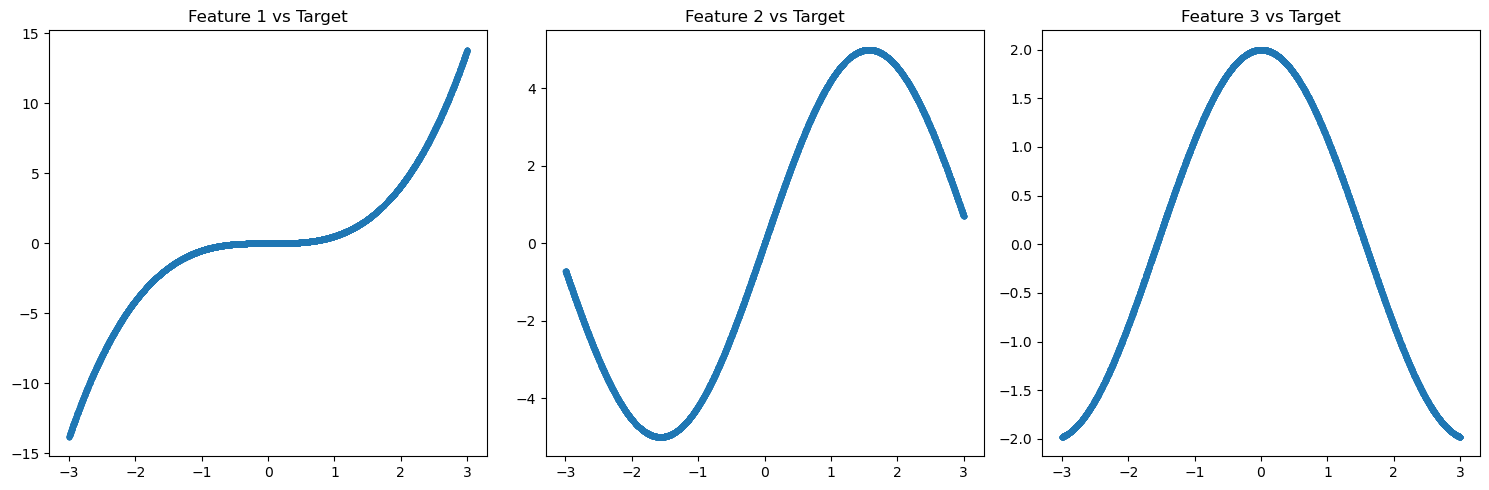

In [33]:
markersize = 3

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot data in each subplot
axes[0].plot(X_train[:, 0], F1, "o", markersize = markersize)
axes[0].set_title("Feature 1 vs Target")

axes[1].plot(X_train[:, 1], F2, "o", markersize = markersize)
axes[1].set_title("Feature 2 vs Target")

axes[2].plot(X_train[:, 2], F3, "o", markersize = markersize)
axes[2].set_title("Feature 3 vs Target")

# Adjust layout for better appearance
plt.tight_layout()

# Show the figure
plt.show()

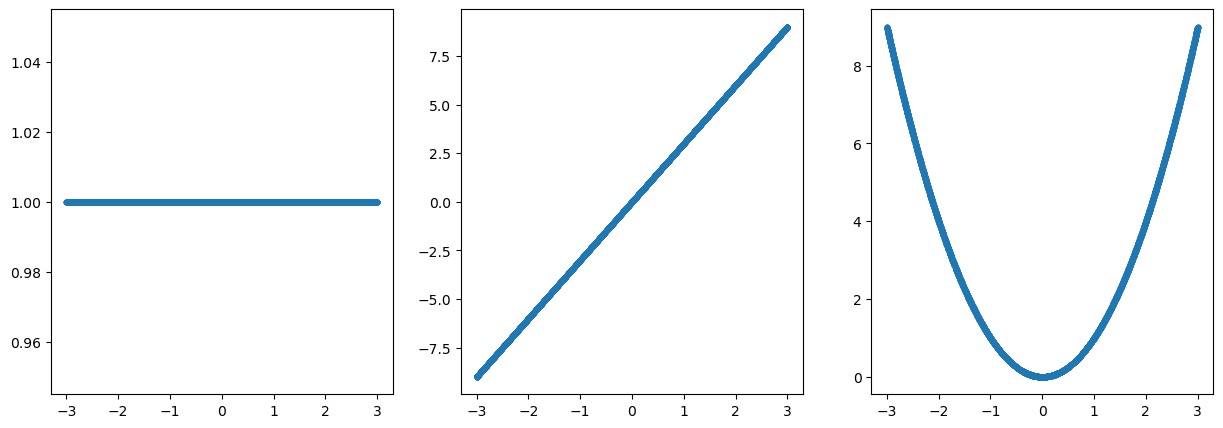

In [34]:
markersize = 3 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(X_train[:,0], S1, "o", markersize = markersize)
axes[1].plot(X_train[:,1], S2, "o", markersize = markersize)
axes[2].plot(X_train[:,2], S3, "o", markersize = markersize)
plt.show()

### Comparing a unregularized and robustified model on data without outliers:

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
X_val_scaled = torch.tensor(scaler.fit_transform(X_val), dtype = torch.float32)
X_test_scaled = torch.tensor(scaler.fit_transform(X_test), dtype = torch.float32)

In [36]:
scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()

y_train_scaled = torch.tensor(scaler1.fit_transform(y_train), dtype = torch.float32)
y_val_scaled = torch.tensor(scaler2.fit_transform(y_val), dtype = torch.float32)
y_test_scaled = torch.tensor(scaler3.fit_transform(y_test), dtype = torch.float32)

In [37]:
nam = NormalNAMLSS(3)
nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
mu, sigma = nam.forward(X_test_scaled)

Epoch 0 - Train Loss: 1.7711 - Val Loss: 1.7653
Epoch 1 - Train Loss: 1.7675 - Val Loss: 1.7617
Epoch 2 - Train Loss: 1.7639 - Val Loss: 1.7580
Epoch 3 - Train Loss: 1.7602 - Val Loss: 1.7544
Epoch 4 - Train Loss: 1.7566 - Val Loss: 1.7508
Epoch 5 - Train Loss: 1.7529 - Val Loss: 1.7472
Epoch 6 - Train Loss: 1.7493 - Val Loss: 1.7436
Epoch 7 - Train Loss: 1.7457 - Val Loss: 1.7400
Epoch 8 - Train Loss: 1.7420 - Val Loss: 1.7363
Epoch 9 - Train Loss: 1.7384 - Val Loss: 1.7327
Epoch 10 - Train Loss: 1.7347 - Val Loss: 1.7291
Epoch 11 - Train Loss: 1.7311 - Val Loss: 1.7255
Epoch 12 - Train Loss: 1.7274 - Val Loss: 1.7218
Epoch 13 - Train Loss: 1.7238 - Val Loss: 1.7182
Epoch 14 - Train Loss: 1.7201 - Val Loss: 1.7146
Epoch 15 - Train Loss: 1.7165 - Val Loss: 1.7110
Epoch 16 - Train Loss: 1.7128 - Val Loss: 1.7073
Epoch 17 - Train Loss: 1.7092 - Val Loss: 1.7037
Epoch 18 - Train Loss: 1.7055 - Val Loss: 1.7001
Epoch 19 - Train Loss: 1.7019 - Val Loss: 1.6964
Epoch 20 - Train Loss: 1.6982 

In [38]:
robust_nam = NormalNAMLSS(3)
robust_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(3))
rob_mu, rob_sigma = robust_nam.forward(X_test_scaled)

Epoch 0 - Train Loss: 1.7778 - Val Loss: 1.7752
Epoch 1 - Train Loss: 1.7749 - Val Loss: 1.7723
Epoch 2 - Train Loss: 1.7720 - Val Loss: 1.7694
Epoch 3 - Train Loss: 1.7691 - Val Loss: 1.7665
Epoch 4 - Train Loss: 1.7662 - Val Loss: 1.7636
Epoch 5 - Train Loss: 1.7633 - Val Loss: 1.7607
Epoch 6 - Train Loss: 1.7604 - Val Loss: 1.7578
Epoch 7 - Train Loss: 1.7575 - Val Loss: 1.7550
Epoch 8 - Train Loss: 1.7546 - Val Loss: 1.7521
Epoch 9 - Train Loss: 1.7517 - Val Loss: 1.7492
Epoch 10 - Train Loss: 1.7489 - Val Loss: 1.7464
Epoch 11 - Train Loss: 1.7460 - Val Loss: 1.7435
Epoch 12 - Train Loss: 1.7431 - Val Loss: 1.7406
Epoch 13 - Train Loss: 1.7403 - Val Loss: 1.7378
Epoch 14 - Train Loss: 1.7374 - Val Loss: 1.7350
Epoch 15 - Train Loss: 1.7346 - Val Loss: 1.7321
Epoch 16 - Train Loss: 1.7318 - Val Loss: 1.7293
Epoch 17 - Train Loss: 1.7289 - Val Loss: 1.7265
Epoch 18 - Train Loss: 1.7261 - Val Loss: 1.7237
Epoch 19 - Train Loss: 1.7233 - Val Loss: 1.7209
Epoch 20 - Train Loss: 1.7205 

In [39]:
strict_nam = NormalNAMLSS(3)
strict_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(1))
strict_mu, strict_sigma = strict_nam.forward(X_test_scaled)

Epoch 0 - Train Loss: 0.9997 - Val Loss: 0.9984
Epoch 1 - Train Loss: 0.9985 - Val Loss: 0.9973
Epoch 2 - Train Loss: 0.9974 - Val Loss: 0.9961
Epoch 3 - Train Loss: 0.9962 - Val Loss: 0.9950
Epoch 4 - Train Loss: 0.9951 - Val Loss: 0.9938
Epoch 5 - Train Loss: 0.9939 - Val Loss: 0.9927
Epoch 6 - Train Loss: 0.9928 - Val Loss: 0.9915
Epoch 7 - Train Loss: 0.9916 - Val Loss: 0.9904
Epoch 8 - Train Loss: 0.9905 - Val Loss: 0.9892
Epoch 9 - Train Loss: 0.9894 - Val Loss: 0.9881
Epoch 10 - Train Loss: 0.9882 - Val Loss: 0.9869
Epoch 11 - Train Loss: 0.9871 - Val Loss: 0.9858
Epoch 12 - Train Loss: 0.9860 - Val Loss: 0.9847
Epoch 13 - Train Loss: 0.9848 - Val Loss: 0.9835
Epoch 14 - Train Loss: 0.9837 - Val Loss: 0.9824
Epoch 15 - Train Loss: 0.9826 - Val Loss: 0.9813
Epoch 16 - Train Loss: 0.9815 - Val Loss: 0.9802
Epoch 17 - Train Loss: 0.9803 - Val Loss: 0.9790
Epoch 18 - Train Loss: 0.9792 - Val Loss: 0.9779
Epoch 19 - Train Loss: 0.9781 - Val Loss: 0.9768
Epoch 20 - Train Loss: 0.9770 

### Clean Dataset - Mean Estimation

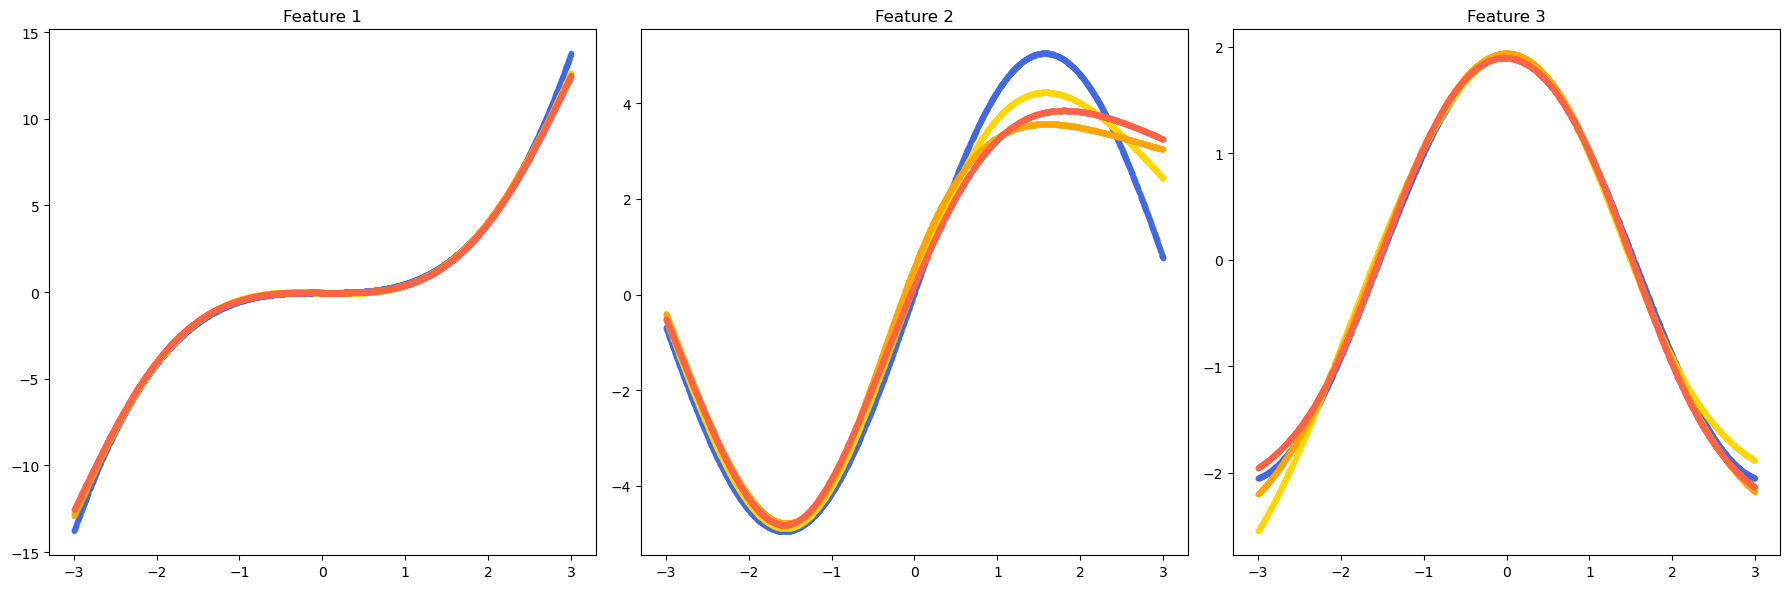

In [40]:
# Configuration
markersize = 3
alpha = 0.4

true_color = "royalblue"
unregulated_color = "gold"
robust_color = "orange"
strict_color = "tomato"

########## Marginal Effect Plots ##########
mu_components, sigma_components = nam.marginal_effects(X_test_scaled)
robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test_scaled)
strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test_scaled)

########## Rescaling the values ##########
mu_components = mu_components * scaler1.scale_ + scaler1.mean_
robust_mu_components = robust_mu_components * scaler2.scale_ + scaler2.mean_
strict_mu_components = strict_mu_components * scaler3.scale_ + scaler3.mean_

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot for Feature 1
axes[0].plot(X_test[:, 0], F1_test - F1_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[0].plot(X_test[:, 0], mu_components[:, 0] - mu_components[:, 0].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[0].plot(X_test[:, 0], robust_mu_components[:, 0] - robust_mu_components[:, 0].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[0].plot(X_test[:, 0], strict_mu_components[:, 0] - strict_mu_components[:, 0].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[0].set_title("Feature 1")

# Plot for Feature 2
axes[1].plot(X_test[:, 1], F2_test - F2_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[1].plot(X_test[:, 1], mu_components[:, 1] - mu_components[:, 1].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[1].plot(X_test[:, 1], robust_mu_components[:, 1] - robust_mu_components[:, 1].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[1].plot(X_test[:, 1], strict_mu_components[:, 1] - strict_mu_components[:, 1].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[1].set_title("Feature 2")

# Plot for Feature 3
axes[2].plot(X_test[:, 2], F3_test - F3_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[2].plot(X_test[:, 2], mu_components[:, 2] - mu_components[:, 2].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[2].plot(X_test[:, 2], robust_mu_components[:, 2] - robust_mu_components[:, 2].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[2].plot(X_test[:, 2], strict_mu_components[:, 2] - strict_mu_components[:, 2].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[2].set_title("Feature 3")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

### Clean Dataset - Sigma Estimation

In [41]:
sigma_components = sigma_components * scaler1.scale_
robust_sigma_components = robust_sigma_components * scaler2.scale_
strict_sigma_components = strict_sigma_components * scaler3.scale_

sigma_components = utils.inv_softplus(sigma_components)
robust_sigma_components = utils.inv_softplus(robust_sigma_components)
strict_sigma_components = utils.inv_softplus(strict_sigma_components)

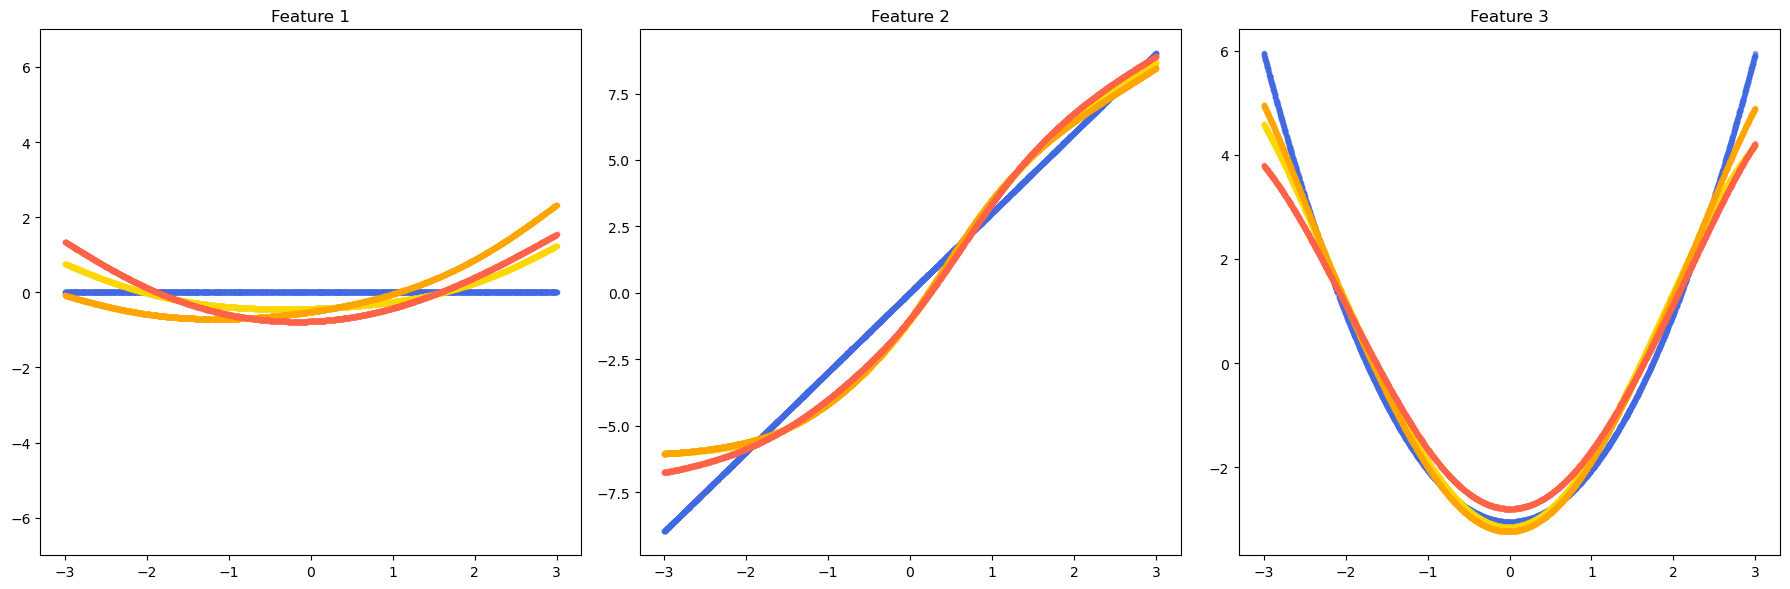

In [42]:
markersize = 3
alpha = 0.4

true_color = "royalblue"
unregulated_color = "gold"
robust_color = "orange"
strict_color = "tomato"

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot for Feature 2
axes[0].plot(X_test[:, 0], S1_test - S1_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[0].plot(X_test[:, 0], sigma_components[:, 0] - sigma_components[:, 0].mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[0].plot(X_test[:, 0], robust_sigma_components[:, 0] - robust_sigma_components[:, 0].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[0].plot(X_test[:, 0], strict_sigma_components[:, 0] - strict_sigma_components[:, 0].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[0].set_ylim([-7,7])
axes[0].set_title("Feature 1")

# Plot for Feature 2
axes[1].plot(X_test[:, 1], S2_test - S2_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[1].plot(X_test[:, 1], sigma_components[:, 1] - sigma_components[:, 1].mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[1].plot(X_test[:, 1], robust_sigma_components[:, 1] - robust_sigma_components[:, 1].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[1].plot(X_test[:, 1], strict_sigma_components[:, 1] - strict_sigma_components[:, 1].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[1].set_title("Feature 2")

# Plot for Feature 2
axes[2].plot(X_test[:, 2], S3_test - S3_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[2].plot(X_test[:, 2], sigma_components[:, 2] - sigma_components[:, 2].mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[2].plot(X_test[:, 2], robust_sigma_components[:, 2] - robust_sigma_components[:, 2].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[2].plot(X_test[:, 2], strict_sigma_components[:, 2] - strict_sigma_components[:, 2].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[2].set_title("Feature 3")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

### Corrupted Data Example

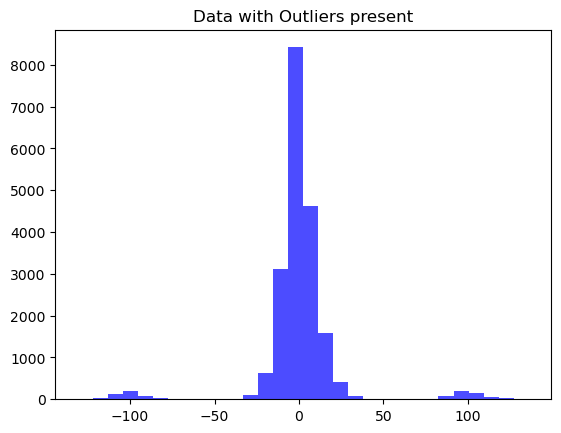

In [61]:
########## Training Dataset ##########
prop_corrupt = 0.2
n_train, n_val = 20000, 10000
BIAS = 100
Uniform = dist.Uniform(-3, 3)
X_train = Uniform.sample(sample_shape = [n_train, 3])

F1 = (0.8 * X_train[:,0])**3
F2 = 5 * np.sin(X_train[:,1])
F3 = 2 * np.cos(X_train[:,2])

S1 = torch.ones(n_train)
S2 = X_train[:,1] * 3
S3 = X_train[:,2]**2

y_train = F1 + F2 + F3 + torch.normal(torch.zeros(n_train), std = F.softplus(S1 + S2 + S3))
y_train = y_train.view(n_train, 1)

corrupted_indices = random.sample(range(1, n_train), int(n_train * prop_corrupt))
sign = (2 * torch.randint(0, 2, (len(corrupted_indices),)) - 1).unsqueeze(1)
y_train[corrupted_indices] = y_train[corrupted_indices] + BIAS * sign

plt.hist(y_train.detach().numpy(), bins = 30, color = "blue", alpha = 0.7)
plt.title("Data with Outliers present")
plt.show()

########## Validation Dataset ###########

X_val = Uniform.sample(sample_shape = [n_val, 3])

F1_val = (0.8 * X_val[:,0])**3
F2_val = 5 * np.sin(X_val[:,1])
F3_val = 2 * np.cos(X_val[:,2])

S1_val = torch.ones(n_val)
S2_val = X_val[:,1] * 3
S3_val = X_val[:,2]**2

y_val = F1_val + F2_val + F3_val + torch.normal(torch.zeros(n_val), std = F.softplus(S1_val + S2_val + S3_val))
y_val = y_val.view(n_val, 1)

corrupted_indices = random.sample(range(1, n_val), int(n_val * prop_corrupt))
sign = (2 * torch.randint(0, 2, (len(corrupted_indices),)) - 1).unsqueeze(1)
y_val[corrupted_indices] = y_val[corrupted_indices] + BIAS * sign

########## Testing Dataset ##########
n_test = 5000
X_test = Uniform.sample(sample_shape = [n_test, 3])

F1_test = (0.8 * X_test[:,0])**3
F2_test = 5 * np.sin(X_test[:,1])
F3_test = 2 * np.cos(X_test[:,2])

S1_test = torch.ones(n_test)
S2_test = X_test[:, 1] * 3
S3_test = X_test[:, 2] ** 2

y_test = F1_test + F2_test + F3_test + torch.normal(torch.zeros(n_test), std = F.softplus(S1_test + S2_test + S3_test))
y_test = y_test.view(n_test, 1)

corrupted_indices = random.sample(range(1, n_test), int(n_test * prop_corrupt))
sign = (2 * torch.randint(0, 2, (len(corrupted_indices),)) - 1).unsqueeze(1)
y_test[corrupted_indices] = y_test[corrupted_indices] + BIAS * sign

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
X_val_scaled = torch.tensor(scaler.fit_transform(X_val), dtype = torch.float32)
X_test_scaled = torch.tensor(scaler.fit_transform(X_test), dtype = torch.float32)

In [63]:
scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()

y_train_scaled = torch.tensor(scaler1.fit_transform(y_train), dtype = torch.float32)
y_val_scaled = torch.tensor(scaler2.fit_transform(y_val), dtype = torch.float32)
y_test_scaled = torch.tensor(scaler3.fit_transform(y_test), dtype = torch.float32)

In [64]:
nam = NormalNAMLSS(3)
nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
mu, sigma = nam.forward(X_test_scaled)

Epoch 0 - Train Loss: 1.7127 - Val Loss: 1.7091
Epoch 1 - Train Loss: 1.7084 - Val Loss: 1.7048
Epoch 2 - Train Loss: 1.7041 - Val Loss: 1.7005
Epoch 3 - Train Loss: 1.6998 - Val Loss: 1.6963
Epoch 4 - Train Loss: 1.6955 - Val Loss: 1.6921
Epoch 5 - Train Loss: 1.6914 - Val Loss: 1.6880
Epoch 6 - Train Loss: 1.6872 - Val Loss: 1.6840
Epoch 7 - Train Loss: 1.6831 - Val Loss: 1.6799
Epoch 8 - Train Loss: 1.6791 - Val Loss: 1.6760
Epoch 9 - Train Loss: 1.6751 - Val Loss: 1.6721
Epoch 10 - Train Loss: 1.6712 - Val Loss: 1.6682
Epoch 11 - Train Loss: 1.6673 - Val Loss: 1.6644
Epoch 12 - Train Loss: 1.6634 - Val Loss: 1.6606
Epoch 13 - Train Loss: 1.6596 - Val Loss: 1.6569
Epoch 14 - Train Loss: 1.6559 - Val Loss: 1.6532
Epoch 15 - Train Loss: 1.6522 - Val Loss: 1.6496
Epoch 16 - Train Loss: 1.6485 - Val Loss: 1.6460
Epoch 17 - Train Loss: 1.6449 - Val Loss: 1.6425
Epoch 18 - Train Loss: 1.6414 - Val Loss: 1.6390
Epoch 19 - Train Loss: 1.6378 - Val Loss: 1.6355
Epoch 20 - Train Loss: 1.6344 

In [65]:
robust_nam = NormalNAMLSS(3)
robust_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(3))
rob_mu, rob_sigma = robust_nam.forward(X_test_scaled)

Epoch 0 - Train Loss: 1.5145 - Val Loss: 1.5105
Epoch 1 - Train Loss: 1.5112 - Val Loss: 1.5073
Epoch 2 - Train Loss: 1.5079 - Val Loss: 1.5040
Epoch 3 - Train Loss: 1.5047 - Val Loss: 1.5008
Epoch 4 - Train Loss: 1.5014 - Val Loss: 1.4976
Epoch 5 - Train Loss: 1.4983 - Val Loss: 1.4944
Epoch 6 - Train Loss: 1.4951 - Val Loss: 1.4913
Epoch 7 - Train Loss: 1.4919 - Val Loss: 1.4881
Epoch 8 - Train Loss: 1.4888 - Val Loss: 1.4850
Epoch 9 - Train Loss: 1.4857 - Val Loss: 1.4820
Epoch 10 - Train Loss: 1.4827 - Val Loss: 1.4789
Epoch 11 - Train Loss: 1.4796 - Val Loss: 1.4759
Epoch 12 - Train Loss: 1.4766 - Val Loss: 1.4729
Epoch 13 - Train Loss: 1.4736 - Val Loss: 1.4700
Epoch 14 - Train Loss: 1.4707 - Val Loss: 1.4670
Epoch 15 - Train Loss: 1.4678 - Val Loss: 1.4641
Epoch 16 - Train Loss: 1.4649 - Val Loss: 1.4613
Epoch 17 - Train Loss: 1.4620 - Val Loss: 1.4585
Epoch 18 - Train Loss: 1.4592 - Val Loss: 1.4557
Epoch 19 - Train Loss: 1.4564 - Val Loss: 1.4529
Epoch 20 - Train Loss: 1.4536 

In [66]:
strict_nam = NormalNAMLSS(3)
strict_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(1))
strict_mu, strict_sigma = strict_nam.forward(X_test_scaled)

Epoch 0 - Train Loss: 0.9718 - Val Loss: 0.9709
Epoch 1 - Train Loss: 0.9707 - Val Loss: 0.9698
Epoch 2 - Train Loss: 0.9697 - Val Loss: 0.9687
Epoch 3 - Train Loss: 0.9686 - Val Loss: 0.9677
Epoch 4 - Train Loss: 0.9675 - Val Loss: 0.9666
Epoch 5 - Train Loss: 0.9665 - Val Loss: 0.9655
Epoch 6 - Train Loss: 0.9654 - Val Loss: 0.9645
Epoch 7 - Train Loss: 0.9644 - Val Loss: 0.9634
Epoch 8 - Train Loss: 0.9633 - Val Loss: 0.9624
Epoch 9 - Train Loss: 0.9622 - Val Loss: 0.9613
Epoch 10 - Train Loss: 0.9612 - Val Loss: 0.9603
Epoch 11 - Train Loss: 0.9601 - Val Loss: 0.9592
Epoch 12 - Train Loss: 0.9591 - Val Loss: 0.9582
Epoch 13 - Train Loss: 0.9581 - Val Loss: 0.9572
Epoch 14 - Train Loss: 0.9570 - Val Loss: 0.9561
Epoch 15 - Train Loss: 0.9560 - Val Loss: 0.9551
Epoch 16 - Train Loss: 0.9550 - Val Loss: 0.9541
Epoch 17 - Train Loss: 0.9539 - Val Loss: 0.9531
Epoch 18 - Train Loss: 0.9529 - Val Loss: 0.9521
Epoch 19 - Train Loss: 0.9519 - Val Loss: 0.9510
Epoch 20 - Train Loss: 0.9509 

### Corrupted Dataset - Mean Estimation

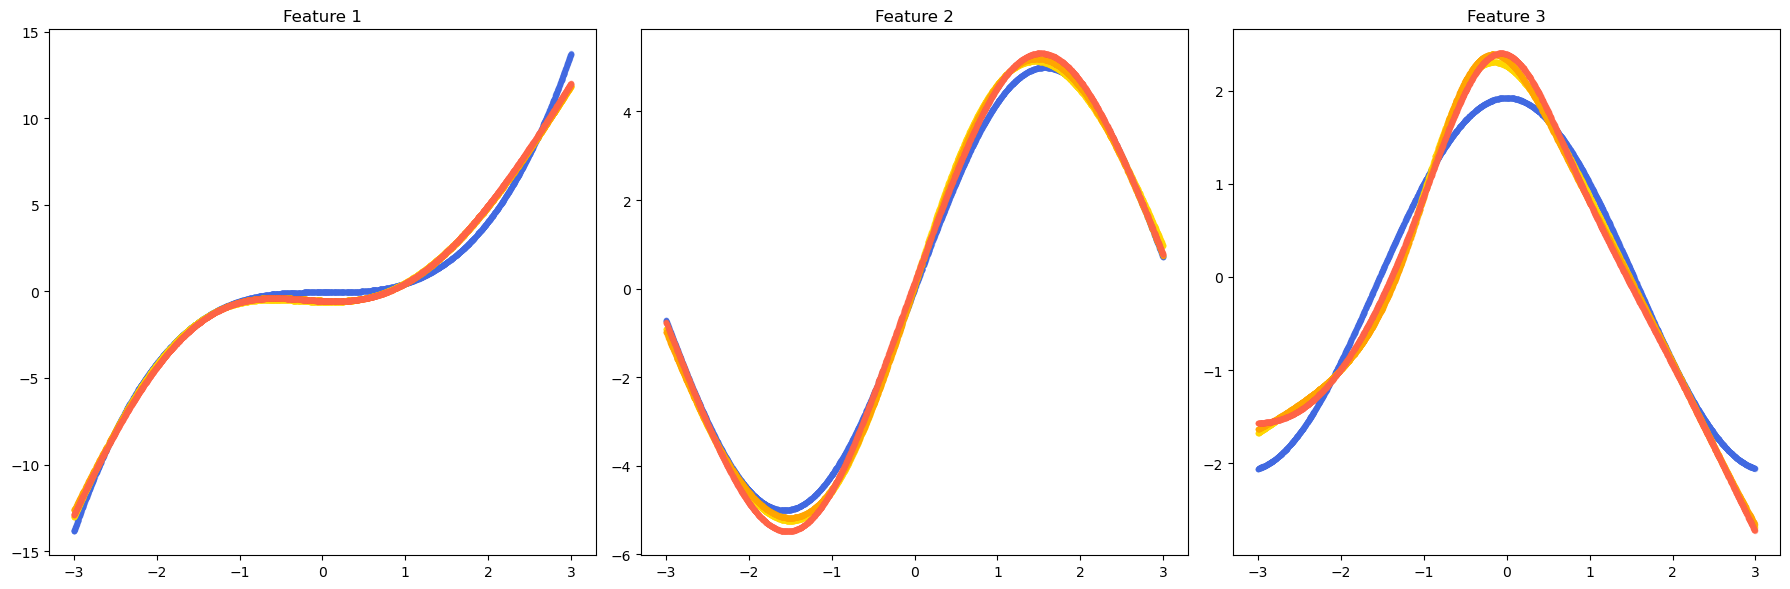

In [67]:
# Configuration
markersize = 3
alpha = 0.4

true_color = "royalblue"
unregulated_color = "gold"
robust_color = "orange"
strict_color = "tomato"

########## Marginal Effect Plots ##########
mu_components, sigma_components = nam.marginal_effects(X_test_scaled)
robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test_scaled)
strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test_scaled)

########## Rescaling the values ##########
mu_components = mu_components * scaler1.scale_ + scaler1.mean_
robust_mu_components = robust_mu_components * scaler2.scale_ + scaler2.mean_
strict_mu_components = strict_mu_components * scaler3.scale_ + scaler3.mean_

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot for Feature 1
axes[0].plot(X_test[:, 0], F1_test - F1_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[0].plot(X_test[:, 0], mu_components[:, 0] - mu_components[:, 0].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[0].plot(X_test[:, 0], robust_mu_components[:, 0] - robust_mu_components[:, 0].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[0].plot(X_test[:, 0], strict_mu_components[:, 0] - strict_mu_components[:, 0].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[0].set_title("Feature 1")

# Plot for Feature 2
axes[1].plot(X_test[:, 1], F2_test - F2_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[1].plot(X_test[:, 1], mu_components[:, 1] - mu_components[:, 1].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[1].plot(X_test[:, 1], robust_mu_components[:, 1] - robust_mu_components[:, 1].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[1].plot(X_test[:, 1], strict_mu_components[:, 1] - strict_mu_components[:, 1].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[1].set_title("Feature 2")

# Plot for Feature 3
axes[2].plot(X_test[:, 2], F3_test - F3_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[2].plot(X_test[:, 2], mu_components[:, 2] - mu_components[:, 2].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[2].plot(X_test[:, 2], robust_mu_components[:, 2] - robust_mu_components[:, 2].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[2].plot(X_test[:, 2], strict_mu_components[:, 2] - strict_mu_components[:, 2].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[2].set_title("Feature 3")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

### Corrupted Dataset - Sigma Estimation

In [68]:
sigma_components = sigma_components * scaler1.scale_
robust_sigma_components = robust_sigma_components * scaler2.scale_
strict_sigma_components = strict_sigma_components * scaler3.scale_

sigma_components = utils.inv_softplus(sigma_components)
robust_sigma_components = utils.inv_softplus(robust_sigma_components)
strict_sigma_components = utils.inv_softplus(strict_sigma_components)

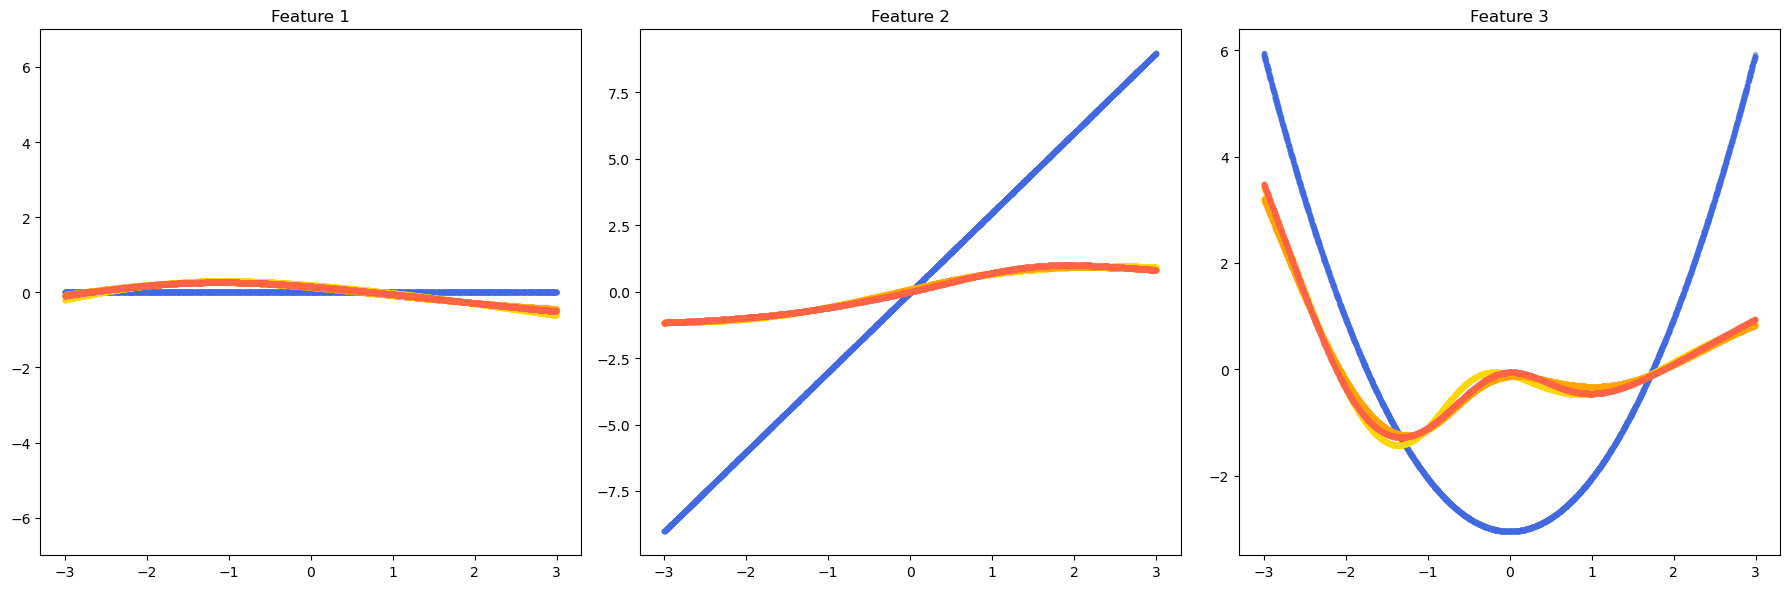

In [69]:
markersize = 3
alpha = 0.4

true_color = "royalblue"
unregulated_color = "gold"
robust_color = "orange"
strict_color = "tomato"

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot for Feature 1
axes[0].plot(X_test[:, 0], S1_test - S1_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[0].plot(X_test[:, 0], sigma_components[:, 0] - sigma_components[:, 0].mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[0].plot(X_test[:, 0], robust_sigma_components[:, 0] - robust_sigma_components[:, 0].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[0].plot(X_test[:, 0], strict_sigma_components[:, 0] - strict_sigma_components[:, 0].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[0].set_ylim([-7,7])
axes[0].set_title("Feature 1")

# Plot for Feature 2
axes[1].plot(X_test[:, 1], S2_test - S2_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[1].plot(X_test[:, 1], sigma_components[:, 1] - sigma_components[:, 1].mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[1].plot(X_test[:, 1], robust_sigma_components[:, 1] - robust_sigma_components[:, 1].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[1].plot(X_test[:, 1], strict_sigma_components[:, 1] - strict_sigma_components[:, 1].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[1].set_title("Feature 2")

# Plot for Feature 3
axes[2].plot(X_test[:, 2], S3_test - S3_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[2].plot(X_test[:, 2], sigma_components[:, 2] - sigma_components[:, 2].mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[2].plot(X_test[:, 2], robust_sigma_components[:, 2] - robust_sigma_components[:, 2].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[2].plot(X_test[:, 2], strict_sigma_components[:, 2] - strict_sigma_components[:, 2].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[2].set_title("Feature 3")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

### Ideen:
- Extremere Kontaminierung
    - Variation des Korruptions-Anteils
    - Veränderung der Größenordnung
- Drittes Penalisiertes NN hinzufügen, um besser Trend zu erkennen
- Betrachtung von true y vs predicted y im test-set
- Getrennte Schätzung von Mu und Sigma
- Standardisierung von y